# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/AIML/')

### Load the training data from train.csv file

In [0]:
train= pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [28]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [30]:
print(train.head(2))
print(train.dtypes)
filename = train['filename']

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
filename    object
width        int64
height       int64
class       object
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object


In [0]:
path = []
for name in filename:
    path = 'images/images/' + filename
    path.append(path)

In [75]:
path[2]

'images/images/raccoon-63.jpg'

In [42]:
coords = np.zeros((len(path), 4))
coords.shape

(173, 4)

In [43]:
train.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [44]:
train.loc[0,'width']

259

In [0]:
for i in range(0,len(path)):
    image_width=train.loc[i,'width'].astype('int32')
    image_height=train.loc[i,'height'].astype('int32')
    x0=train.loc[i,'xmin'].astype('int32')
    y0=train.loc[i,'ymin'].astype('int32')
    x1=train.loc[i,'xmax'].astype('int32')
    y1=train.loc[i,'ymax'].astype('int32')
    coords[i, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[i, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
    coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
    coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height # Normalize bounding box by image size

In [46]:
coords[172,3]

66.44808743169399

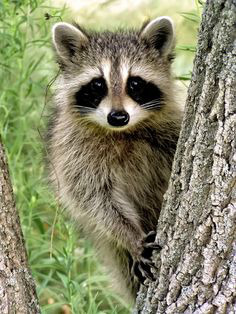

In [48]:
#Showing the 12th image
Image.open(path[14])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
#Reading all the images as batch_images
batch_images = np.zeros((len(path), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i in range(0,len(path)):
    img = Image.open(path[i]) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [50]:
batch_images.shape

(173, 128, 128, 3)

W0714 09:52:49.988664 139664352610176 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


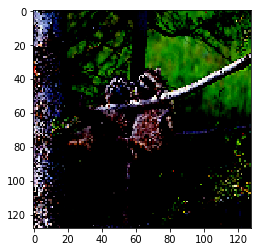

In [74]:
#Showing the first image from the array
plt.imshow(batch_images[3])
plt.show()

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [52]:
#Importing MobileNet Model
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1) 
#freezing layers
for layer in model.layers:
    layer.trainable = False
#Adding Layers
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) #Predictions of coordinates

model = Model(inputs=model.input, outputs=x)

W0714 09:49:32.923505 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



17227776/17225924 [==============================] - 1s 0us/step


In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [0]:
gt = coords

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [56]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

W0714 09:49:53.859268 139664352610176 deprecation.py:323] From <ipython-input-55-a811784d62ce>:25: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Epoch 1/30
173/173 [==============================] - 4s 20ms/step - loss: 2792.1305 - IoU: 0.0841
Epoch 2/30
173/173 [==============================] - 0s 1ms/step - loss: 634.1440 - IoU: 0.4365
Epoch 3/30
173/173 [==============================] - 0s 1ms/step - loss: 664.6460 - IoU: 0.5322
Epoch 4/30
173/173 [==============================] - 0s 994us/step - loss: 559.9333 - IoU: 0.5333
Epoch 5/30
173/173 [==============================] - 0s 1ms/step - loss: 338.7561 - IoU: 0.5805
Epoch 6/30
173/173 [==============================] - 0s 1ms/step - loss: 285.8328 - IoU: 0.5669
Epoch 7/30
173/173 [==============================] - 0s 1ms/step - loss: 241.8072 - IoU: 0.6061
Epoch 8/30
173/173 [==============================] - 0s 1ms/step - loss: 192.0094 - IoU: 0.6644
Epoch 9/30
173/173 [==============================] - 0s 1ms/step - loss: 161.3939 - IoU: 0.7004
Epoch 10/30
173/173 [==============================] - 0s 1ms/step - loss: 140.1901 - IoU: 0.7142
Epoch 11/30
173/173 [====

### Pick a test image from the given data

In [69]:
unscaled=Image.open(path[110])
unscaled.size

(600, 399)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
scaled=unscaled.resize((128, 128))
scaled=preprocess_input(np.array(scaled, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([scaled]))[0] # Predict the BBox

In [72]:
region

array([  6.675118 ,   7.9838533,  86.119286 , 125.89508  ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

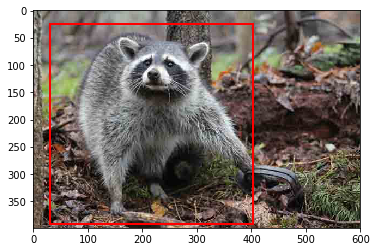

In [73]:
image_width,image_height = unscaled.size
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Change your present working directory

In [0]:
import os
os.chdir('/content/drive/My Drive/AIML/')



### Load your data file

In [4]:
df = pd.read_csv('/content/drive/My Drive/AIML/daily-minimum-temperatures-in-me.csv', index_col='Date')
print(df.head())


            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


#### Plot data

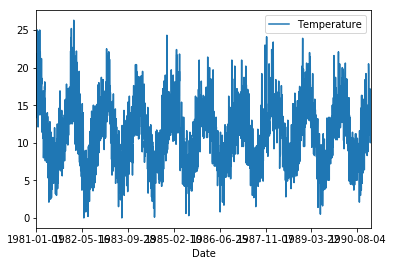

In [5]:
df.plot()

#### Descibe your dataframe

In [6]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [7]:
print(df.isnull().sum())
print(df.isnull().any(axis=1).sum())
print(len(df[df['Temperature'] == 0]))

Temperature    0
dtype: int64
0
2


#### Drop null values

In [8]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(3650, 1)
(3650, 1)


#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d1745d30>]],
      dtype=object)

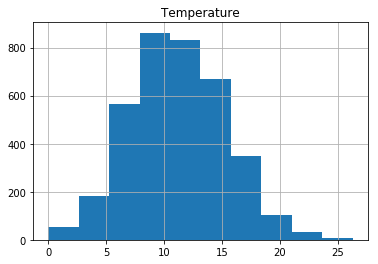

In [9]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [10]:
# Scaled Data
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
dataset = df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [12]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [13]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [0]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [15]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [17]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [19]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')


W0714 09:03:41.900511 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 09:03:41.952265 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 09:03:41.959337 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 09:03:42.261484 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Summarize your model

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [21]:
model.fit(X_train, y_train, epochs=200, batch_size=batch_size, verbose=2, shuffle=True)

W0714 09:03:48.075455 139664352610176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0714 09:03:48.457472 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0714 09:03:48.485074 139664352610176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/200
 - 17s - loss: 0.0191
Epoch 2/200
 - 13s - loss: 0.0160
Epoch 3/200
 - 13s - loss: 0.0149
Epoch 4/200
 - 13s - loss: 0.0145
Epoch 5/200
 - 13s - loss: 0.0146
Epoch 6/200
 - 13s - loss: 0.0149
Epoch 7/200
 - 13s - loss: 0.0146
Epoch 8/200
 - 13s - loss: 0.0142
Epoch 9/200
 - 12s - loss: 0.0141
Epoch 10/200
 - 12s - loss: 0.0133
Epoch 11/200
 - 13s - loss: 0.0134
Epoch 12/200
 - 13s - loss: 0.0131
Epoch 13/200
 - 12s - loss: 0.0131
Epoch 14/200
 - 12s - loss: 0.0128
Epoch 15/200
 - 13s - loss: 0.0126
Epoch 16/200
 - 12s - loss: 0.0124
Epoch 17/200
 - 12s - loss: 0.0122
Epoch 18/200
 - 12s - loss: 0.0121
Epoch 19/200
 - 13s - loss: 0.0122
Epoch 20/200
 - 12s - loss: 0.0119
Epoch 21/200
 - 12s - loss: 0.0119
Epoch 22/200
 - 12s - loss: 0.0117
Epoch 23/200
 - 12s - loss: 0.0114
Epoch 24/200
 - 12s - loss: 0.0113
Epoch 25/200
 - 12s - loss: 0.0115
Epoch 26/200
 - 12s - loss: 0.0111
Epoch 27/200
 - 12s - loss: 0.0111
Epoch 28/200
 - 12s - loss: 0.0110
Epoch 29/200
 - 12s - loss: 0

## Make Predictions and Evaluate your model

In [22]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.72 RMSE
Test Score: 2.59 RMSE


## Plot the results

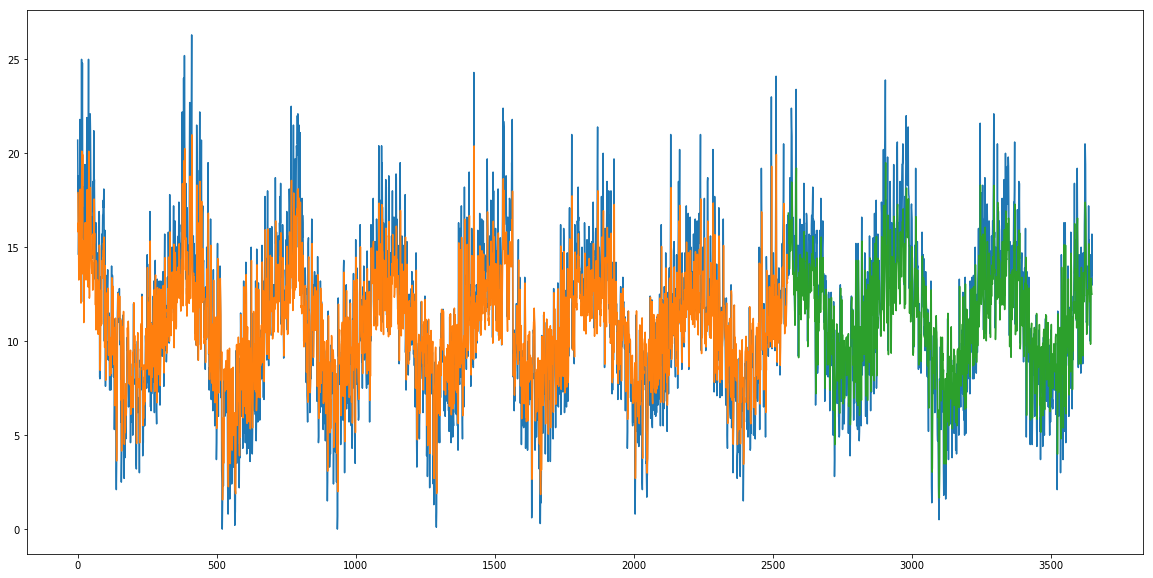

In [23]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()